# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 6: *PolarHoughTransform*
Line detection by the Hough transform with polar parametrisation
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, createImageF, plotImageF, plotImageL, createScaleImageL
from ImageOperatorsUtilities import applyCannyEdgeDetector
from ImagePropertiesUtilities import imageMaxMin, peakDetectorImageL
from PlotUtilities import plot3DHistogram 

# Math and iteration
from math import fabs, sqrt, pi, sin, cos
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    gaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    upperT = Upper threshold
    lowerT = Lower threshold
    peakDetection = Percentage of the maximum peak value that is considered for threshold

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter6/Input/")
imageName = "Road.png"
gaussianKernelSize = 7
sobelKernelSize = 3
upperT = 0.5
lowerT = 0.3
peakDetection = 0.7

### Read and show input image

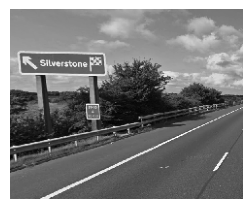

In [3]:
inputImage, width, height  = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 3)

### Compute edges

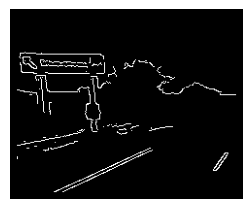

In [4]:
magnitude, angle = applyCannyEdgeDetector(inputImage, gaussianKernelSize, sobelKernelSize, upperT, lowerT)
plotImageF(magnitude, figureSize = 3) 

### Gather evidence 

In [5]:
# Line parametrisation for normals from 0 to 360 degrees and r positive form the image centre 
# Parametrisation r = (x-cx) * cos(t) + (y-cy) * sin(t)
maxLenght = int(sqrt(height*height + width*width) / 2)
accumulator = createImageF(maxLenght,360)
cx = int(width / 2)
cy = int(height / 2)

# Gather evidence 
for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0:
        for m in range(0,360):
            angle = (m * pi) / 180.0
            r = (x-cx) * cos(angle) + (y-cy) * sin(angle)
            bucket = int(r)
            if bucket> 0 and bucket < maxLenght - 1:
                weight = r - int(r)
                accumulator[m, bucket] += (1.0 - weight)
                accumulator[m, bucket+1] += weight

### Find maximum

In [6]:
maximum, _ = imageMaxMin(accumulator)
peakThreshold = peakDetection * maximum

### Plot accumulator

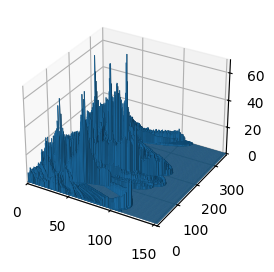

In [7]:
plot3DHistogram(accumulator)

### Peak detection

In [8]:
peaks = peakDetectorImageL(accumulator, peakThreshold)

### Draw lines on output image

In [9]:
# Prepare output image as a dark version of the input
outputImage = createScaleImageL(inputImage, 0.5)


# Draw lines on output image
for peakIndex in range(1,len(peaks)):
    m = (peaks[peakIndex])[0]
    r = (peaks[peakIndex])[1]  

    strength = int(255.0 * accumulator[m, r] / maximum)
    angle = (m * pi) / 180.0
    if fabs(sin(angle)) >  fabs(cos(angle)):
        for x in range(0, width -1):
            y = int( (r - (x-cx) * cos(angle) ) / sin(angle)) + cy
            if y > 0 and y < height -1:
                outputImage[y,x] = strength
                outputImage[y+1,x] = strength
    else:
        for y in range(0, height -1):
            x = int( (r - (y-cy) * sin(angle) ) / cos(angle)) + cx
            if x > 0 and x < width -1:
                outputImage[y,x] = strength
                outputImage[y+1,x] = strength

### Show image with detected lines        

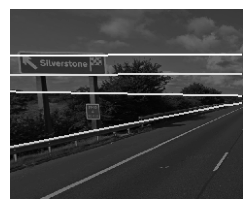

In [10]:
plotImageL(outputImage, figureSize = 3)